# Carga y normalización

In [2]:
# Instala semopy si falta
import sys, subprocess, pkg_resources
required = {"semopy", "graphviz", "pandas", "numpy"}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    print("Instalando:", missing)
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])

# Imports
import pandas as pd
import numpy as np
from semopy import Model, semplot

# 1) Cargar archivos (sin convertir value labels)
df20 = pd.read_stata("Latinobarometro_2020_Esp_Stata_v1_0.dta", convert_categoricals=False)
df23 = pd.read_stata("Latinobarometro_2023_Esp_Stata_v1_0.dta", convert_categoricals=False)
df24 = pd.read_stata("Latinobarometro_2024_Stata_esp_v20250817.dta", convert_categoricals=False)

# 2) detectar id y crear id,wave
def detect_id(df):
    for c in ["IDNUM","idnum","Idnum","id_num","NUMINVES","numinves"]:
        if c in df.columns:
            return c
    raise ValueError("No se encontró ID en la base.")
df20["id"] = df20[detect_id(df20)].astype(int)
df23["id"] = df23[detect_id(df23)].astype(int)
df24["id"] = df24[detect_id(df24)].astype(int)
df20["wave"] = 2020
df23["wave"] = 2023
df24["wave"] = 2024

/tmp/ipython-input-4192479378.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


Instalando: {'semopy'}


/tmp/ipython-input-4192479378.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df24["id"] = df24[detect_id(df24)].astype(int)
/tmp/ipython-input-4192479378.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df24["wave"] = 2024


In [3]:
# 3) mapping confirmado (usaste/confirmaste estos nombres)
mapping_2020 = {
    "p1st": "felicidad",
    "p46stgbs": "interes_politica",
    "p49stgbs": "identificacion_partidaria",
    "p18st": "polarizacion_continua",
    "p20st_a": "democratico",
    "p22stm_b": "nodemocratico",
    "p9stgbs": "confianza",
    "s4": "econ_personal",
    "p4stgbs": "econ_pais",
    "edad": "edad",
    "s16": "educacion",
    "sexo": "genero"
}
mapping_2023 = {
    "P1ST": "felicidad",
    "P40STGBS": "interes_politica",
    "P42STGBS": "identificacion_partidaria",
    "P16ST": "polarizacion_continua",
    "P18ST_A": "democratico",
    "P18STM_B": "nodemocratico",
    "P9STGBS": "confianza",
    "S4": "econ_personal",
    "P4STGBS": "econ_pais",
    "edad": "edad",
    "S11": "educacion",
    "sexo": "genero"
}
mapping_2024 = {
    "P1ST": "felicidad",
    "P36STGBS": "interes_politica",
    "P26ST": "eficacia_voto",
    "P25ST": "representacion",
    "P16ST": "polarizacion_continua",
    "P38STGBS": "identificacion_partidaria",
    "P18ST.A": "democratico",
    "P18ST.B": "nodemocratico",
    "P18ST.C": "porencima",
    "P10STGBS": "confianza",
    "S4": "econ_personal",
    "P4ST": "econ_pais",
    "EDAD": "edad",
    "S11": "educacion",
    "SEXO": "genero"
}

def apply_mapping(df, mp):
    df2 = df.copy()
    not_found = []
    for raw, std in mp.items():
        if raw in df2.columns:
            df2[std] = df2[raw]
        else:
            not_found.append(raw)
    return df2, not_found

df20r, miss20 = apply_mapping(df20, mapping_2020)
df23r, miss23 = apply_mapping(df23, mapping_2023)
df24r, miss24 = apply_mapping(df24, mapping_2024)

if miss20: print("⚠️ Missing mapping 2020:", miss20)
if miss23: print("⚠️ Missing mapping 2023:", miss23)
if miss24: print("⚠️ Missing mapping 2024:", miss24)

# 4) Variables estándar a mantener (si faltan quedan NaN)
vars_std = [
    "felicidad","interes_politica","eficacia_voto","representacion",
    "polarizacion_continua","identificacion_partidaria","democratico","nodemocratico",
    "confianza","econ_personal","econ_pais","edad","educacion","genero"
]

def safe_slice(df, cols):
    df2 = df.copy()
    for c in cols:
        if c not in df2.columns:
            df2[c] = np.nan
    return df2[["id","wave"] + cols]

df20s = safe_slice(df20r, vars_std)
df23s = safe_slice(df23r, vars_std)
df24s = safe_slice(df24r, vars_std)

df_long = pd.concat([df20s, df23s, df24s], ignore_index=True)
print("df_long shape:", df_long.shape)

df_long shape: (58623, 16)


In [4]:
# 1) Conversión explícita (idéntica a 2024)
conversion = {
    "derecha": 10,
    "izquierda": 0,
    "Ninguno": np.nan,
    "No contesta": np.nan,
    "No sabe": np.nan,
    97: np.nan,
    99: np.nan,
    "97": np.nan,
    "99": np.nan
}

def convertir(val):
    if val in conversion:
        return conversion[val]
    try:
        num = float(val)
        if num in [97, 99]:
            return np.nan
        return num
    except:
        return np.nan

# 2) Aplicar conversión solo donde existe escala ideológica
df_long["escala_lr"] = df_long["polarizacion_continua"].apply(convertir)

# 3) Distancia al centro (0–5), idéntica a 2024
df_long["polarizacion_continua"] = np.abs(df_long["escala_lr"] - 5)

# 4) Limpieza
df_long = df_long.drop(columns="escala_lr")

In [5]:
conversion = {
    3: 2,  # No muy satisfecho
    4: 1,  # Para nada satisfecho
    2: 3,  # Bastante satisfecho
    1: 4   # Muy satisfecho
}


# Reemplazar valores en la columna P1ST
df_long["felicidad"] = df_long["felicidad"].map(conversion)

# Interés en la política (1=Muy interesado ... 4=Nada interesado) → invertimos para que valores altos = más interés
df_long["interes_politica"] = df_long["interes_politica"].replace({1:4, 2:3, 3:2, 4:1})

# Sentimiento partidario (1=Sí, 2=No)
df_long["identificacion_partidaria"] = df_long["identificacion_partidaria"].replace({1:1, 2:0})

# Representación política (1=Sí, 2=No)
df_long["representacion"] = df_long["representacion"].replace({1:1, 2:0})

# Eficacia política (P26ST: 1=cree que su voto hace diferencia, 2=no)
df_long["eficacia_voto"] = df_long["eficacia_voto"].replace({1:1, 2:0})

In [6]:
# === 2. Conversiones ===
##################################################################
# Edad: asegurar numérico
df_long["edad"] = pd.to_numeric(df_long["edad"], errors="coerce")

##################################################################
# Género: 1 = hombre, 2 = mujer → 0/1
df_long["genero"] = df_long["genero"].replace({1: 0, 2: 1})

##################################################################
# Educación: usar S16 (1 = sin estudios ... 14 = universidad)
# Paso 1: convertir a numérico
df_long["educacion_num"] = pd.to_numeric(df_long["educacion"], errors="coerce")

# Paso 2: definir el escalador manual
def escalar_educacion(x):
    if pd.isna(x):
        return np.nan
    if x == 1:
        return 0  # sin estudios
    elif 2 <= x <= 13:
        return x - 1  # años reales (1–12)
    elif x == 14:  # universitario incompleto
        return 14
    elif x == 15:  # universitario completo
        return 16
    elif x == 16:  # técnico incompleto
        return 13
    elif x == 17:  # técnico completo
        return 14
    else:
        return np.nan

df_long["educacion"] = df_long["educacion_num"].apply(escalar_educacion)

##################################################################
# El salario o el sueldo que Ud percibe, les permite...
df_long["econ_personal"] = pd.to_numeric(df_long["econ_personal"], errors="coerce")

# Paso 2: diccionario de conversión
conv_s5 = {
    1: 4,  # les alcanza bien → muy buena situación
    2: 3,  # les alcanza justo
    3: 2,  # no les alcanza
    4: 1,  # no les alcanza, grandes dificultades
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}

# Paso 3: aplicar conversión
df_long["econ_personal"] = df_long["econ_personal"].replace(conv_s5)

##################################################################
# Edad al cuadrado
df_long["edad2"]=df_long["edad"]**2


##################################################################
# ¿Cómo calificaría en general la situación económica actual del país? Diría Ud. que es...?
# Paso 1: convertir P6 a numérico
df_long["econ_pais"] = pd.to_numeric(df_long["econ_pais"], errors="coerce")

# Paso 2: diccionario de conversión
# Invertimos la escala para que valores altos = percepción económica más positiva
conv_p6 = {
    1: 5,  # muy buena  → muy positiva
    2: 4,  # buena
    3: 3,  # regular
    4: 2,  # mala
    5: 1,  # muy mala → muy negativa
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}

# Paso 3: aplicar conversión
df_long["econ_pais"] = df_long["econ_pais"].replace(conv_p6)



##################################################################
# P10STGBS. Hablando en general, ¿Diría Ud. que se puede confiar en la mayoría de las personas o que uno nunca es lo suficientemente cuidadoso en el trato con los demás?
df_long["confianza"] = pd.to_numeric(df_long["confianza"], errors="coerce")
conv_p10 = {
    1: 1,  # Se puede confiar en la mayoría
    2: 0,  # Uno nunca es suficientemente cuidadoso
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}

# Paso 3: aplicar conversión
df_long["confianza"] = df_long["confianza"].replace(conv_p10)

In [7]:
vars_modelo = ["felicidad","interes_politica","eficacia_voto", "representacion",
               "polarizacion_continua","identificacion_partidaria","democratico",
               "nodemocratico", "confianza","econ_personal","econ_pais",
               "edad", "educacion","genero"]

tablas_por_wave = {}

for w, df_w in df_long.groupby("wave"):
    tabla = df_w[vars_modelo].describe().T
    tabla["n_miss"] = df_w[vars_modelo].isna().sum()
    tabla["%_miss"] = (tabla["n_miss"] / len(df_w) * 100).round(1)
    tablas_por_wave[w] = tabla


In [8]:
tablas_por_wave[2024]

,count,mean,std,min,25%,50%,75%,max,n_miss,%_miss
felicidad,19067.0,3.151256,0.836020,1.0,3.0,3.0,4.0,4.0,147,0.8
interes_politica,19044.0,2.047311,0.986022,1.0,1.0,2.0,3.0,4.0,170,0.9
eficacia_voto,18507.0,0.648457,0.477465,0.0,0.0,1.0,1.0,1.0,707,3.7
representacion,18467.0,0.225592,0.417983,0.0,0.0,0.0,0.0,1.0,747,3.9
polarizacion_continua,16832.0,2.458175,2.034877,0.0,0.0,2.0,5.0,5.0,2382,12.4
identificacion_partidaria,18918.0,0.338778,0.473307,0.0,0.0,0.0,1.0,1.0,296,1.5
democratico,18556.0,2.126805,0.795386,1.0,2.0,2.0,3.0,4.0,658,3.4
nodemocratico,18550.0,2.446038,0.838372,1.0,2.0,2.0,3.0,4.0,664,3.5
confianza,18843.0,0.154540,0.361475,0.0,0.0,0.0,0.0,1.0,371,1.9
econ_personal,18796.0,3.273888,1.447788,1.0,2.0,3.0,5.0,5.0,418,2.2


# Estandarización

In [9]:
# 5) Estadarizar por ola (z dentro de wave) para las variables que usaremos
# Variables observables que participan en el CFA
obs = ["interes_politica","identificacion_partidaria","democratico","nodemocratico","polarizacion_continua",
       "felicidad","eficacia_voto","representacion", "polarizacion_continua"]

for wave in [2020,2023,2024]:
    mask = df_long["wave"]==wave
    for v in obs:
        if v in df_long.columns:
            col = v
            zcol = f"{v}_{wave}_z"
            # compute z only on that wave
            s = df_long.loc[mask, col].astype(float)
            mean = s.mean(skipna=True)
            sd = s.std(skipna=True)
            if pd.isna(sd) or sd==0:
                # if no variance, fill NaN
                df_long.loc[mask, zcol] = np.nan
            else:
                df_long.loc[mask, zcol] = (s - mean) / sd

In [10]:
vars_z = [
    "felicidad", "interes_politica", "eficacia_voto", "representacion",
    "polarizacion_continua", "identificacion_partidaria",
    "democratico", "nodemocratico",
    "polarizacion_continua", "econ_pais", "econ_personal",
    "edad2", "confianza", "edad", "educacion"

]

for v in vars_z:
    df_long[f"{v}_z"] = np.nan

for wave in df_long["wave"].unique():
    mask = df_long["wave"] == wave
    for v in vars_z:
        s = df_long.loc[mask, v].astype(float)
        mean = s.mean(skipna=True)
        sd = s.std(skipna=True)
        if pd.isna(sd) or sd == 0:
            df_long.loc[mask, f"{v}_z"] = np.nan
        else:
            df_long.loc[mask, f"{v}_z"] = (s - mean) / sd

# Modelo por ola

In [14]:
######################## SIN CONTROLES ########################
from semopy import Model, semplot
import pandas as pd

# Subconjunto solo wave = "2024"
df = df_long[df_long["wave"] == 2024]

# Definición del modelo SEM
model_desc = """
# Variables latentes
Engagement =~ interes_politica_z +democratico_z
Polarization =~ polarizacion_continua_z + identificacion_partidaria_z + nodemocratico_z

# Relaciones estructurales
felicidad_z ~ Engagement + Polarization
"""

# Crear el modelo
model = Model(model_desc)

# Ajustar (usa FIML por defecto para manejar NaN)
model.fit(df)

# Resumen de resultados
resumen = model.inspect()
resumen

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,interes_politica_z,~,Engagement,1.000000e+00,-,-,-
1,democratico_z,~,Engagement,-3.912606e-01,0.021203,-18.453401,0.0
2,polarizacion_continua_z,~,Polarization,1.000000e+00,-,-,-
3,identificacion_partidaria_z,~,Polarization,5.393843e+00,0.598692,9.009386,0.0
4,nodemocratico_z,~,Polarization,4.045796e-02,0.038943,1.038891,0.298855
5,felicidad_z,~,Engagement,1.308614e-01,0.019871,6.585477,0.0
6,felicidad_z,~,Polarization,-1.798949e-01,0.053367,-3.370877,0.000749
7,Engagement,~~,Engagement,4.887742e-01,0.027794,17.585652,0.0
8,Polarization,~~,Polarization,3.436729e-02,0.004456,7.712203,0.0
9,Polarization,~~,Engagement,6.252519e-02,0.007082,8.828782,0.0


In [15]:
##################### CON CONTROLES #################################

model_desc = """
Engagement =~ interes_politica_z + eficacia_voto_z + representacion_z + democratico_z
Polarization =~ polarizacion_continua_z + identificacion_partidaria_z + nodemocratico_z
felicidad_z ~ Engagement + Polarization + edad_z + edad2_z + genero + educacion_z + econ_personal_z + econ_pais_z + confianza_z
"""

# Crear el modelo
model = Model(model_desc)

# Ajustar (FIML maneja NaN automáticamente)
model.fit(df)

# Resumen de resultados
Resumen = model.inspect()
resumen


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,interes_politica_z,~,Engagement,1.000000e+00,-,-,-
1,democratico_z,~,Engagement,-3.912606e-01,0.021203,-18.453401,0.0
2,polarizacion_continua_z,~,Polarization,1.000000e+00,-,-,-
3,identificacion_partidaria_z,~,Polarization,5.393843e+00,0.598692,9.009386,0.0
4,nodemocratico_z,~,Polarization,4.045796e-02,0.038943,1.038891,0.298855
5,felicidad_z,~,Engagement,1.308614e-01,0.019871,6.585477,0.0
6,felicidad_z,~,Polarization,-1.798949e-01,0.053367,-3.370877,0.000749
7,Engagement,~~,Engagement,4.887742e-01,0.027794,17.585652,0.0
8,Polarization,~~,Polarization,3.436729e-02,0.004456,7.712203,0.0
9,Polarization,~~,Engagement,6.252519e-02,0.007082,8.828782,0.0


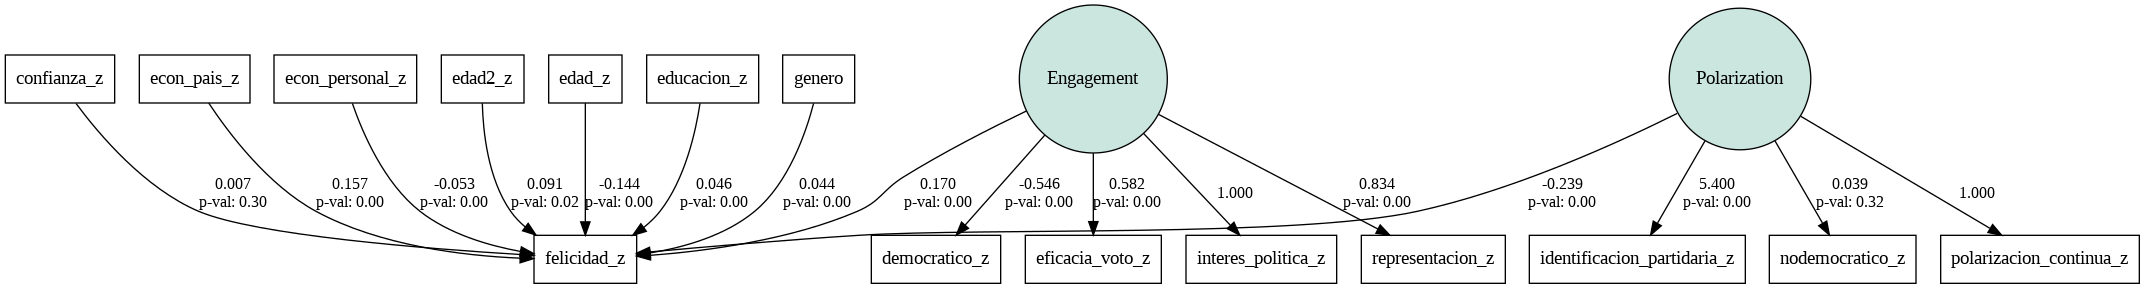

In [16]:
from IPython.display import Image
semplot(model, "diagrama_sem.png")
Image("diagrama_sem.png")

# Modelo

In [ ]:
df_long["edad_grupo"] = pd.cut(
    df_long["edad"],
    bins=[18, 30, 45, 60, 100],
    labels=["18-29", "30-44", "45-59", "60+"]
)



In [ ]:
vars_model = [
    "felicidad_z",
    "interes_politica_z",
    "eficacia_voto_z",
    "representacion_z",
    "polarizacion_continua_z",
    "identificacion_partidaria_z",
    "edad_z",
    "edad2_z",
    "educacion_z",
    "econ_personal_z",
    "econ_pais_z",
    "confianza_z"
]

pseudo = (
    df_long
    .dropna(subset=cohort_cols)
    .groupby(cohort_cols + ["wave"])[vars_model]
    .mean()
    .reset_index()
)


/tmp/ipython-input-3928908444.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cohort_cols + ["wave"])[vars_model]


In [ ]:
pseudo = (
    pseudo
    .loc[pseudo["wave"].isin([2023, 2024])]
    .sort_values(cohort_cols + ["wave"])
    .copy()
)

lag_vars = [
    "felicidad_z",
    "interes_politica_z",
    "eficacia_voto_z",
    "representacion_z",
    "polarizacion_continua_z",
    "identificacion_partidaria_z"
]

for v in lag_vars:
    pseudo[f"{v}_lag"] = (
        pseudo
        .groupby(cohort_cols)[v]
        .shift(1)
    )


/tmp/ipython-input-3124392329.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cohort_cols)[v]
/tmp/ipython-input-3124392329.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cohort_cols)[v]
/tmp/ipython-input-3124392329.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cohort_cols)[v]
/tmp/ipython-input-3124392329.py:20: FutureWarning: The default of observed=False is deprecated and 

In [ ]:
pseudo["Engagement_lag"] = (
    pseudo.groupby(cohort_cols)["interes_politica_z"].shift(1)
)


model_desc = """
Engagement =~ interes_politica_z + eficacia_voto_z + representacion_z
Polarization =~ polarizacion_continua_z + identificacion_partidaria_z

felicidad_z ~ Engagement + Polarization + felicidad_z_lag + edad_z + edad2_z + educacion_z + econ_personal_z + econ_pais_z + confianza_z
"""



/tmp/ipython-input-4032973233.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudo.groupby(cohort_cols)["interes_politica_z"].shift(1)


In [ ]:
from semopy import Model

model = Model(model_desc)

model.fit(
    pseudo
)

resumen = model.inspect()
resumen


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,interes_politica_z,~,Engagement,1.000000e+00,-,-,-
1,eficacia_voto_z,~,Engagement,5.390221e-01,0.072028,7.483542,0.0
2,representacion_z,~,Engagement,1.201242e-01,0.079967,1.502173,0.133052
3,polarizacion_continua_z,~,Polarization,1.000000e+00,-,-,-
4,identificacion_partidaria_z,~,Polarization,-4.870243e-01,0.100002,-4.870132,0.000001
5,felicidad_z,~,Engagement,-3.791309e-02,0.078889,-0.480588,0.63081
6,felicidad_z,~,Polarization,-1.663037e-01,0.07635,-2.178183,0.029392
7,felicidad_z,~,felicidad_z_lag,-1.368580e-01,0.058162,-2.353034,0.018621
8,felicidad_z,~,edad_z,-1.866126e-01,0.073149,-2.551121,0.010738
9,felicidad_z,~,edad2_z,9.283282e-02,0.071552,1.297421,0.194486


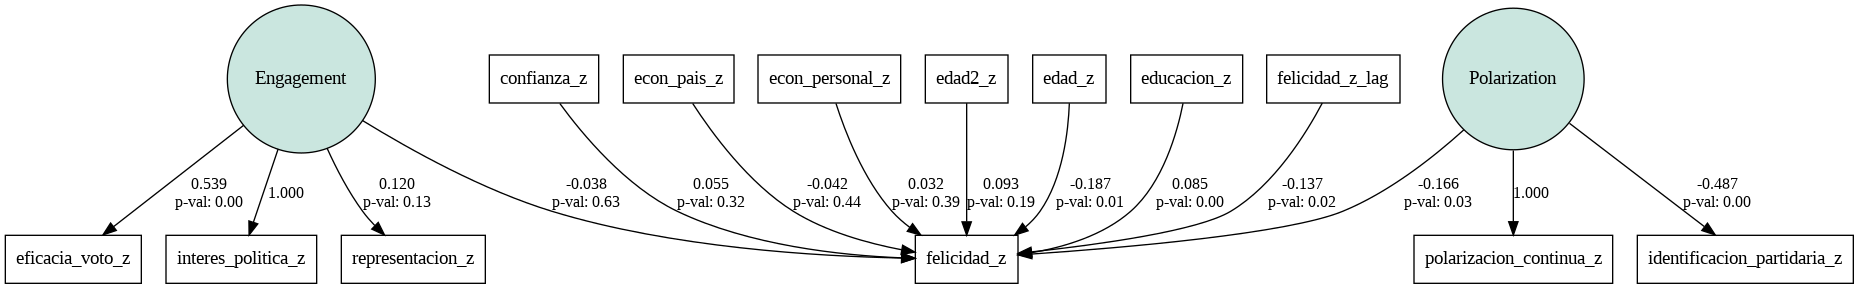

In [ ]:
from IPython.display import Image
semplot(model, "diagrama_sem.png")
Image("diagrama_sem.png")